# Predict the Samples with Model

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [11]:
zip audio_6000.zip ./*

SyntaxError: ignored

In [0]:
!pip install pydub

In [0]:
!pip install soundfile

In [0]:
import re
import cv2
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation

from __future__ import print_function
import tensorflow as tf

import soundfile as sf
from collections import Counter
from pydub import AudioSegment


Using TensorFlow backend.


In [0]:
df = pd.read_csv('/content/gdrive/My Drive/classes.csv',delimiter = ',',engine='python') ## header of classes.

#Categories of environment sound
categories = df.columns.tolist()

classes =      list(df[categories[0]].values)
classes.extend(list(df[categories[1]].values))
classes.extend(list(df[categories[2]].values))
classes.extend(list(df[categories[3]].values))
classes.extend(list(df[categories[4]].values))
df

,NaturePlace,LoudPlace,MusicPlace,QuietPlace,Etc
0,Mountain,Factory,MusicConcert,Home,Traffic
1,Sea,Airport,ClassicConcert,Office,Class
2,Cave,Harbor,Club,Library,Cafe


In [0]:
def play_file(input_path, input_file):
    audio, sampling_rate = librosa.load(os.path.join(input_path,input_file),res_type='kaiser_fast')
    return Audio(os.path.join(input_path,input_file),rate = sampling_rate)


In [0]:

def predict_file(input_path, input_file):

    # sound file을 분석하기 위해 soundfile 패키지 이용
    f = sf.SoundFile(os.path.join(input_path,input_file))
    
    #file을 5초 단위로 자르기 위해서 처음 변수 초기화
    pre_array= []
    # 5초 단위로 파일을 쪼개기 위해서
    t1 = 0
    t2 = t1+5
    second = len(f)/f.samplerate # 오디오 길이 

    #5초 단위로 오디오를 쪼개고, 5초가 되지 않는 오디오의 길이는 버리기 위해서 5로 나누었을 때 몫만 남겨서 count로 만듬
    #count는 즉, 전체 파일을 5초 단위로 쪼갤 때 몇개의 파일이 생성되는지를 알려주는 변수임
    count = int(second/5) # 
    #5초 단위로 파일을 자르고 count의 수만큼만 while문을 돌리기 위해서 조건문을 아래와 같이 사용
    while t1 < (count)*5:
        #pydub에서는 ms가 단위이기 때문에 1000을 곱해서 second 단위로 전환 시켜준다.
        st1 = t1*1000  # 자르기 시작지점
        et2 = t2*1000  # 끝나는 지점
        #생성되는 파일의 이름을 서로 다르게 만들기 위해서 number라는 변수를 이용해 파일 이름이 동일하여 덮어 씌우는 일이 없도록 만든다.
        number = t1/5
        #5초 단위로 자른 오디오를 새로 생성한다.
        newAudio = AudioSegment.from_wav(os.path.join(input_path,input_file))
        #이 때 자르는 위치는 st1 부터 et2 지점 까지이다.
        newAudio = newAudio[st1:et2]
        #임시적으로 생성되는 오디오 파일들이기 때문에 넘버링 번호(number)와 temp_audio를 추가하여서 파일 이름을 만든다.
        name = str(number)+"temp_audio"
        #생성된 파일을 현재 위치 아래에 있는 temp_audio 파일에 만든다. 현재 코드는 temp_audio 폴더가 있어야 돌아가는데 추후에 없으면 그 폴더를 
        #생성하는 방식도 사용할 예정이다.
        newAudio.export(input_path+'temp_audio/'+name+'.wav', format="wav")
        #다음 5초 주기를 위해서 변수를 변화 시킨다.
        t1 = t1+5
        t2 = t1+5
    
    #임시로 생성된 파일의 path를 받아 온다.
    Path = '/content/gdrive/My Drive/temp_audio'
    #5초 단위로 나눈 spectrogram list를 저장하는 파일
    count = 0
    for file_name in (os.listdir(Path)):
        #try:
            #5초 단위로 나눈 파일
            test_file = []
            
            #librosa를 이용하여 임시로 생성된 디렉토리 밑에 있는 파일들을 읽어 와서 오디오 정보와 sampling rate로 분류 한다.
            t_audio, t_sampling_rate = librosa.load(os.path.join(Path,file_name),res_type='kaiser_fast')
            # model에 집어 넣기 위한 test file을 t_audio를 이용하여 생성한다.
            test_file.append([t_audio])
            # 생성된 test_file을 array 형태로 변환 시킨다.
            test_file = np.array(test_file)

            plt.figure(figsize=(20,5))
            plt.subplot(121)

            #librosa의 melspectrogram을 이용하여 model의 입력에 맞는 tensor로 변환 시킨다.
            spectrogram = librosa.feature.melspectrogram(test_file[0][0],t_sampling_rate)
            
            plt.title("Spectrogram"+str(count))
            librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time')
            plt.subplot(122)
            plt.title("Wave")
            librosa.display.waveplot(test_file[0][0], sr=t_sampling_rate)
            plt.ylabel('Amplitude')
            plt.show()
            
            #뽑아낸 spectrogram을 model의 입력 형태로 맞게 변형 시키기 위해 (? ,128, 216, 1)형태로 변형 시킴 이때 맨 앞이 1인 것은 파일이 하나이기 때문
            #한번에 하나씩 변환 시키고 for문이 돌아가 기 때문에
            spectrogram = np.reshape(spectrogram,(1,128, 216,1))
            #입력된 spectrogram으로 model을 이용하여 예측한다음 flatten 합를 이용하여 일차원 배열 형태로 만듬 
            #그 결과 물은 softmax로 만들어진 15개의 확률 배열임 (각 class 별 확률 15개를 가진 배열 생성)

            prediction = list(model.predict(spectrogram).flatten())
            #그 결과 물로 나온 softmax중 가장 큰 확률 값을 가지는 위치의 index 값을 pre_array에 저장한다. 
            pre_array.append(prediction.index(max(prediction)))
            count = count+1
    
    # 모든 파일에 대한 예측이 다 끝나면 이제 가장 많은 빈도수가 나온 class를 찾기 위해 counter 함수를 이용한다.
    cnt = Counter(pre_array)
    # 빈도수를 가진 값을 내림 차순 차례로 반환하는데 가장 많은 것만 찾음으로 1을 집어 넣어서 찾는다. 
    predict_place = cnt.most_common(2)
    
    # 그 다음 빈도수를 찾이 위해서 [0][0]의 위치의 값을 이용한다.
    # 각 카테고리 별로 가진 개수가 3이기 때문에 구한 index 값을 3으로 나누면 카테고리가 나오고 그 index 값 자체는 class 가 된다.
    
    print("\n\nPredicted category:",categories[predict_place[0][0]//3])
    print('\n\nPredicted class:',classes[predict_place[0][0]])
    if(len(predict_place)<2):
      print("\n\nNo Second Predict\n\n\n")
    else:
      print("\n\nSecond Predicted category:",categories[predict_place[1][0]//3])
      print('\n\nSecond Predicted class:',classes[predict_place[1][0]])
      print('\n\n\n\n')

#지정된 디렉토리에 있는 디렉토리 안 파일 다 지우기
def removeAllFile(filePath):
  if os.path.exists(filePath):
    for file in os.scandir(filePath):
      os.remove(file.path)
    return 'RemoveAll File'
  else:
    return 'Directory Not Found'


    

In [0]:
play_file('/content/gdrive/My Drive/test_data/','test_harbor6.wav')

Output hidden; open in https://colab.research.google.com to view.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




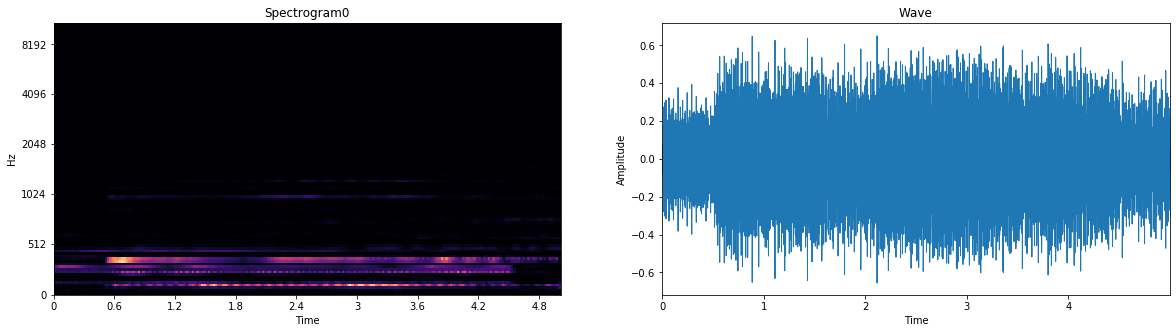

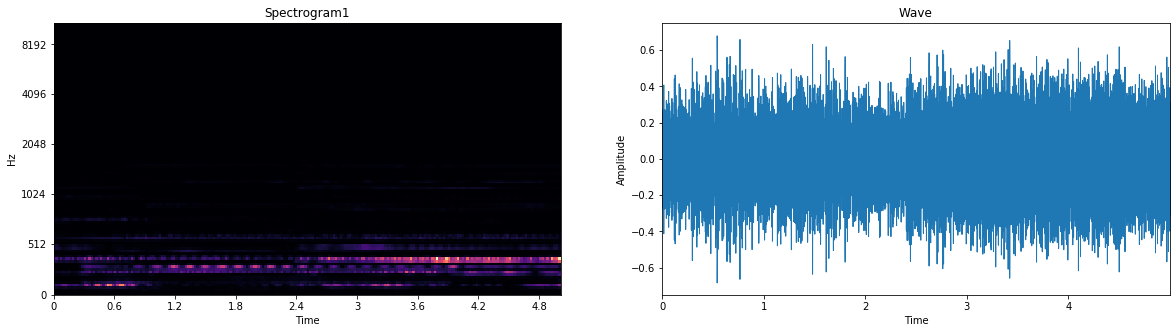

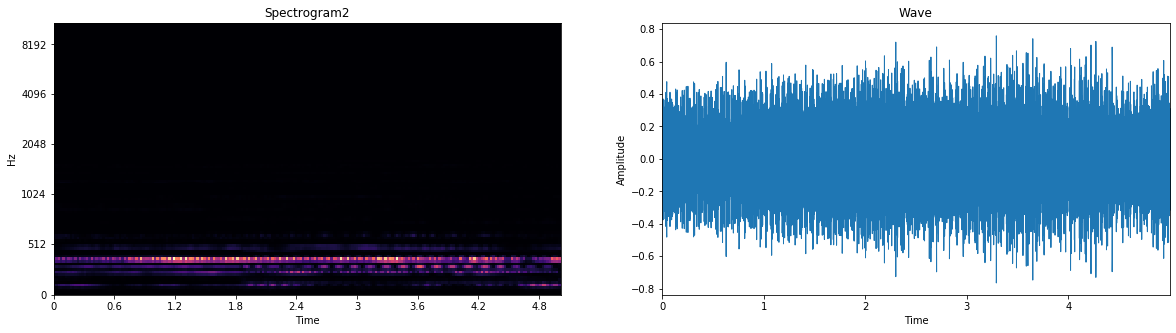

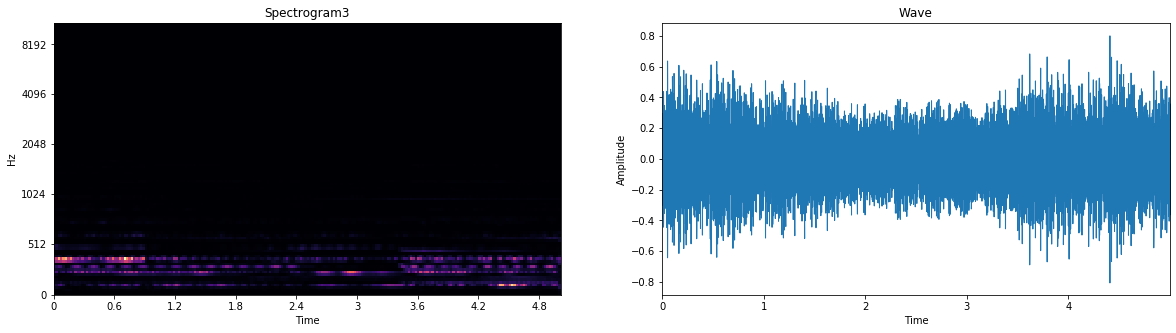

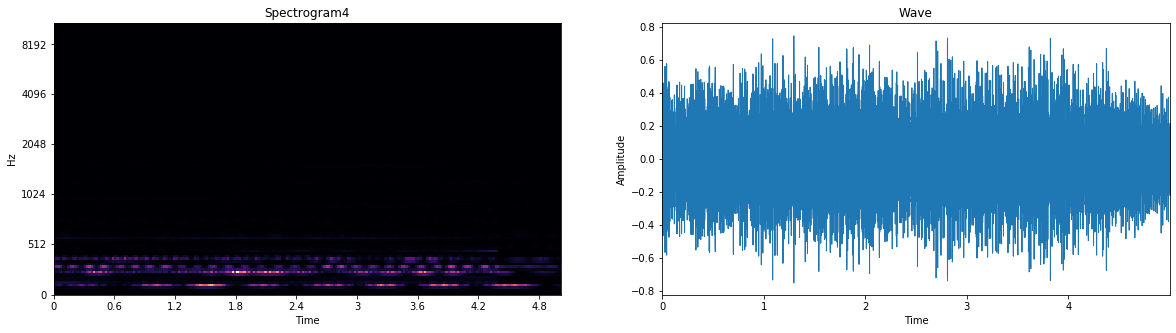

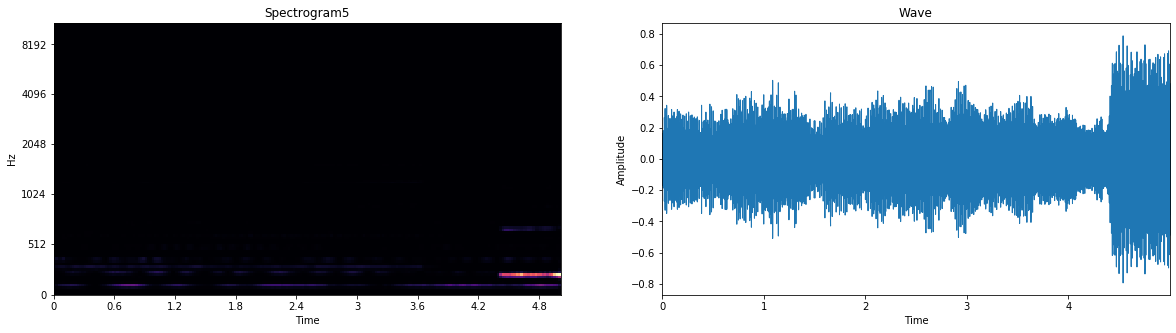



Predicted category: MusicPlace


Predicted class: ClassicConcert


Second Predicted category: Etc


Second Predicted class: Cafe







'RemoveAll File'

In [0]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/train_label15_6000_final.h5')
removeAllFile('/content/gdrive/My Drive/temp_audio')
predict_file('/content/gdrive/My Drive/','test_harbor6.wav')
removeAllFile('/content/gdrive/My Drive/temp_audio')

In [0]:
play_file('/content/gdrive/My Drive/test_data/','test_club9.wav')

Output hidden; open in https://colab.research.google.com to view.

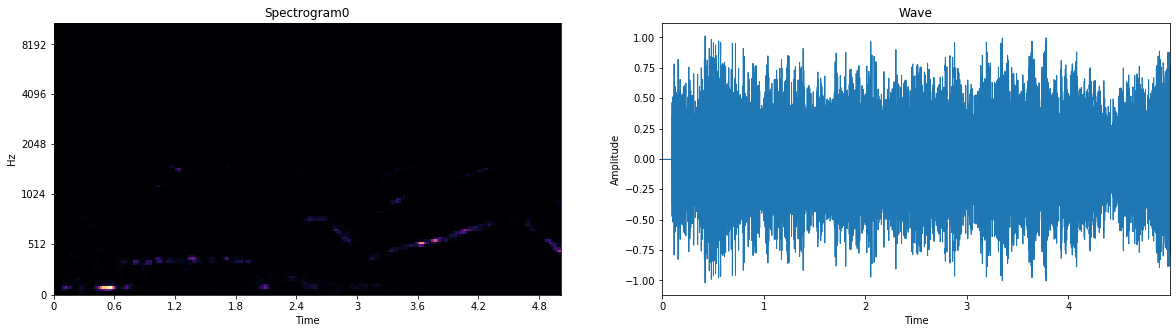

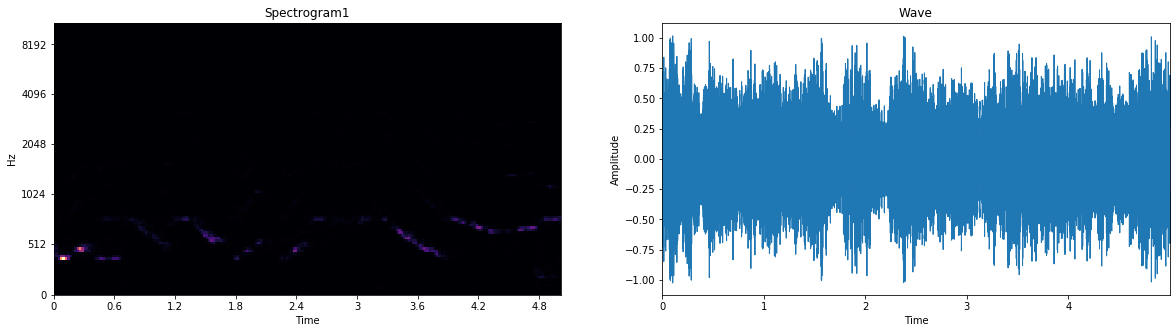

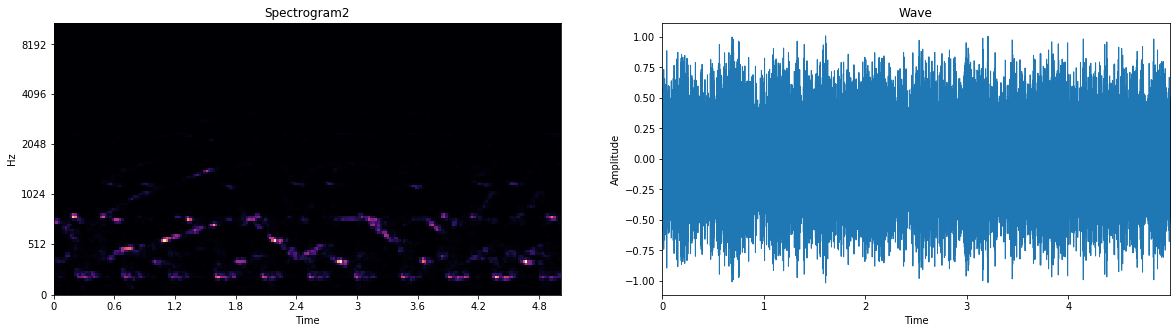

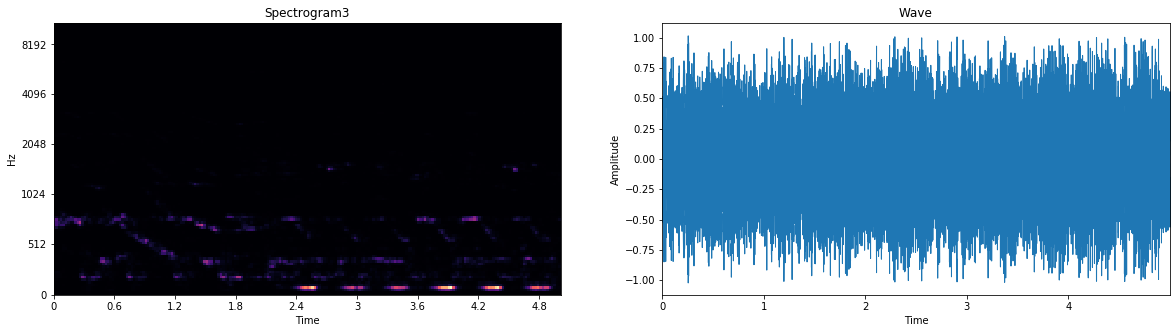

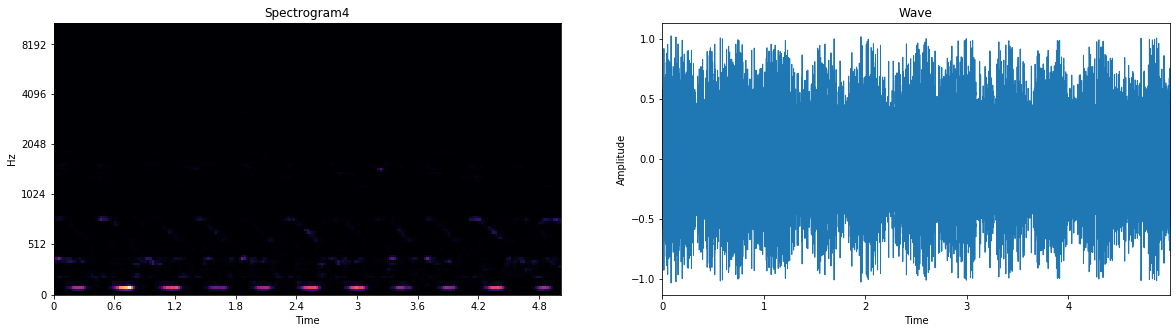

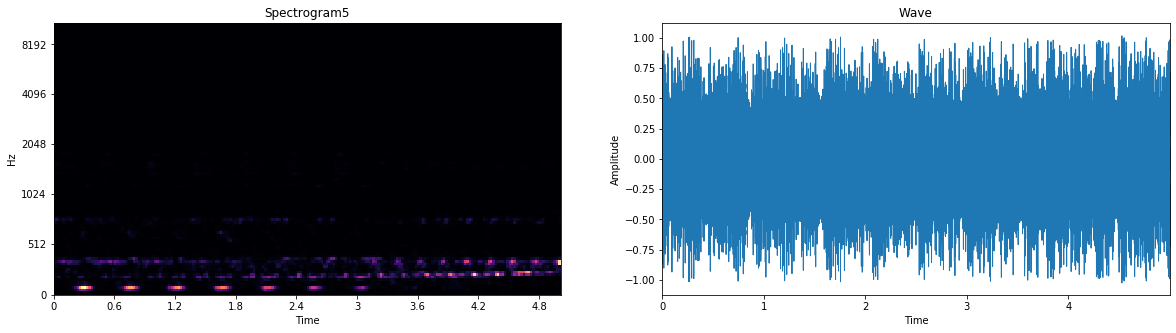



Predicted category: MusicPlace


Predicted class: Club


Second Predicted category: MusicPlace


Second Predicted class: MusicConcert







'RemoveAll File'

In [0]:
model = load_model('/content/gdrive/My Drive/train_label15_6000_final.h5')
removeAllFile('/content/gdrive/My Drive/temp_audio')
predict_file('/content/gdrive/My Drive/','test_club9.wav')
removeAllFile('/content/gdrive/My Drive/temp_audio')